#  SnapDeal Project: Identify customer segments for online retail with the use of K-Means clustering

### 1. Load Data

In [4]:
#Importing necessary libraries
import os
import pandas as pd
import numpy as np

In [5]:
# Load Online Retail Dataset
retail = pd.read_excel(r'C:\Users\HP\Downloads\Online Retail.xlsx', engine = 'openpyxl')

### 2. Understanding Dataset

In [3]:
# Display first 5 rows
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [ ]:
# Summary of dataset
retail.info()

In [15]:
# Statistical Summary of the dataset
retail.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,541909.000000,541909,541909.000000,406829.000000
mean,9.552250,2011-07-04 13:34:57.156386048,4.611114,15287.690570
min,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000
25%,1.000000,2011-03-28 11:34:00,1.250000,13953.000000
50%,3.000000,2011-07-19 17:17:00,2.080000,15152.000000
75%,10.000000,2011-10-19 11:27:00,4.130000,16791.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,218.081158,NaN,96.759853,1713.600303


In [43]:
# Number of rows and columns
retail.shape

(541909, 8)

In [ ]:
# Group by Country and represent it as pie chart
country= retail['Country'].value_counts()
plt.figure(figsize=(15, 10))
plt.pie(country, labels=country.index, autopct='%1.1f%%', startangle=140)
plt.title('Customer Distribution by Country')
plt.show()

In [4]:
# Find Percentage of missing values in all columns
retail.isnull().mean()*100

InvoiceNo       0.000000
StockCode       0.000000
Description     0.268311
Quantity        0.000000
InvoiceDate     0.000000
UnitPrice       0.000000
CustomerID     24.926694
Country         0.000000
dtype: float64

### 3. Data Cleaning

Since the amount of missing data is very small and both Description and CustomerID cannot be filled with random values, it is better to drop the rows with missing values. Additionally, since our analysis focuses on customer segmentation and purchase behavior, CustomerID is essential, so we are dropping rows where it is missing.

In [6]:
# Dropping all the rows with missing values
retail = retail.dropna()

In [46]:
# Percentage of null values
retail.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [22]:
# Summary of dataset
retail.info()

<class 'pandas.core.frame.DataFrame'>
Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      406829 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.9+ MB


In [47]:
# Find Duplicate rows
retail.duplicated().sum()

5225

In [7]:
# Dropping duplicates 
retail = retail.drop_duplicates()

In [ ]:
retail.duplicated().sum()

In [11]:
# Finding if there are any negative values 
negative_price = (retail['UnitPrice'] < 0).sum()
negative_qty = (retail['Quantity'] < 0).sum()

print("Negative UnitPrice count:", negative_price)
print("Negative Quantity count:", negative_qty)


Negative UnitPrice count: 0
Negative Quantity count: 8872


Since the Quantity column has negative values, these likely represent product returns or data entry errors.Since the reason for negative values is unclear, we delete those rows to ensure clean data for clustering.

In [8]:
# Removing negative values from the Quantity column
retail = retail[retail['Quantity'] >= 0]

In [14]:
retail.shape

(392732, 8)

### 4. Transforming Data

Before standardizing or normalizing the data, we need to prepare the data for modeling using RFM (Recency, Frequency, Monetary) Analysis.


In [9]:
# Create a new column Amount to find total amount of purchases
retail['Amount'] = retail['Quantity'] * retail['UnitPrice']


In [16]:
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [10]:
# Create new dataframe which has total amount purchased by each customer
newdf=retail.groupby('CustomerID')['Amount'].sum()
newdf=newdf.reset_index()
newdf.head()

,CustomerID,Amount
0,12346.0,77183.60
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [11]:
# Find the count of transcations each customer had done
frequency = retail.groupby('CustomerID')['InvoiceNo'].count()
frequency=frequency.reset_index()
frequency.head()

,CustomerID,InvoiceNo
0,12346.0,1
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


In [12]:
# Merge the above two dataframes

newdf = pd.merge(newdf,frequency, on='CustomerID', how='inner')
newdf.head()

,CustomerID,Amount,InvoiceNo
0,12346.0,77183.60,1
1,12347.0,4310.00,182
2,12348.0,1797.24,31
3,12349.0,1757.55,73
4,12350.0,334.40,17


In [ ]:
#Recency-computing number of days between last transaction date of a customer and a refernce date.

In [13]:
max_date = max(retail['InvoiceDate'])
max_date

Timestamp('2011-12-09 12:50:00')

In [14]:
# We can see last transaction happened on 9th of december, 2011. So we take this as the reference date. So lets compute the difference

retail['LastPurchaseDays'] = max_date - retail['InvoiceDate']
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount,LastPurchaseDays
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,373 days 04:24:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,373 days 04:24:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00


In [15]:
# Recency max date of last purchase of each customer

min_days = retail.groupby('CustomerID')['LastPurchaseDays'].min()
min_days

CustomerID
12346.0   325 days 02:49:00
12347.0     1 days 20:58:00
12348.0    74 days 23:37:00
12349.0    18 days 02:59:00
12350.0   309 days 20:49:00
                 ...       
18280.0   277 days 02:58:00
18281.0   180 days 01:57:00
18282.0     7 days 01:07:00
18283.0     3 days 00:48:00
18287.0    42 days 03:21:00
Name: LastPurchaseDays, Length: 4339, dtype: timedelta64[ns]

In [16]:
# merge above with the new dataframe

newdf = pd.merge(newdf,min_days,on='CustomerID',how='inner')
newdf.head()

,CustomerID,Amount,InvoiceNo,LastPurchaseDays
0,12346.0,77183.60,1,325 days 02:49:00
1,12347.0,4310.00,182,1 days 20:58:00
2,12348.0,1797.24,31,74 days 23:37:00
3,12349.0,1757.55,73,18 days 02:59:00
4,12350.0,334.40,17,309 days 20:49:00


In [17]:
# Rename columns for better understanding
newdf.rename(columns={'InvoiceNo':'Frequency','LastPurchaseDays':'Recency'},inplace=True)
newdf.head()


,CustomerID,Amount,Frequency,Recency
0,12346.0,77183.60,1,325 days 02:49:00
1,12347.0,4310.00,182,1 days 20:58:00
2,12348.0,1797.24,31,74 days 23:37:00
3,12349.0,1757.55,73,18 days 02:59:00
4,12350.0,334.40,17,309 days 20:49:00


In [18]:
newdf['Recency'] = newdf['Recency'].dt.days

In [19]:
newdf.head()

,CustomerID,Amount,Frequency,Recency
0,12346.0,77183.60,1,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


Lets find out if our data is normally distributed before decising to normalise or standadrise.

##### Visualise Data Distribution

In [20]:
print(newdf[['Amount','Frequency','Recency']].skew())

Amount       19.341403
Frequency    18.043619
Recency       1.246357
dtype: float64


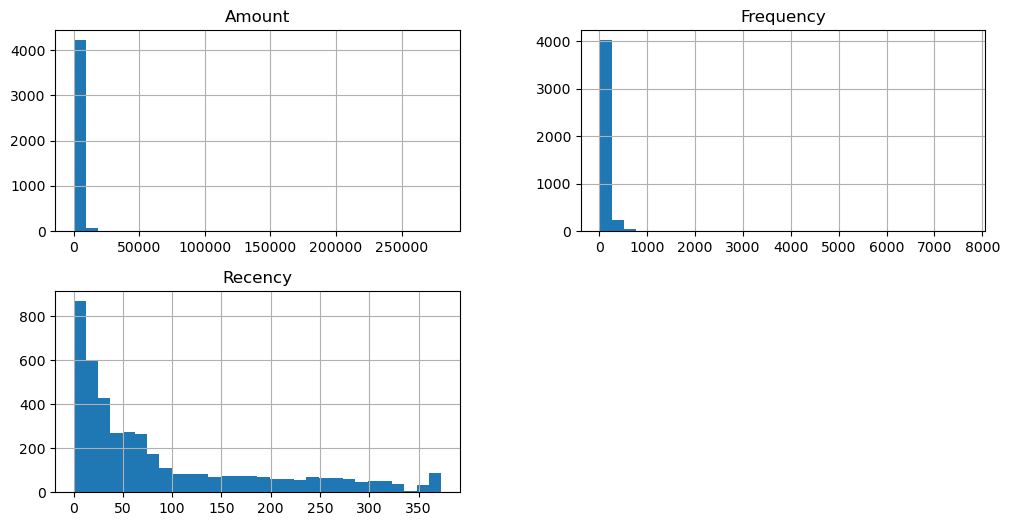

In [21]:
import matplotlib.pyplot as plt
# Plot histograms
newdf[['Amount','Frequency','Recency']].hist(bins=30, figsize=(12, 6))
plt.show()

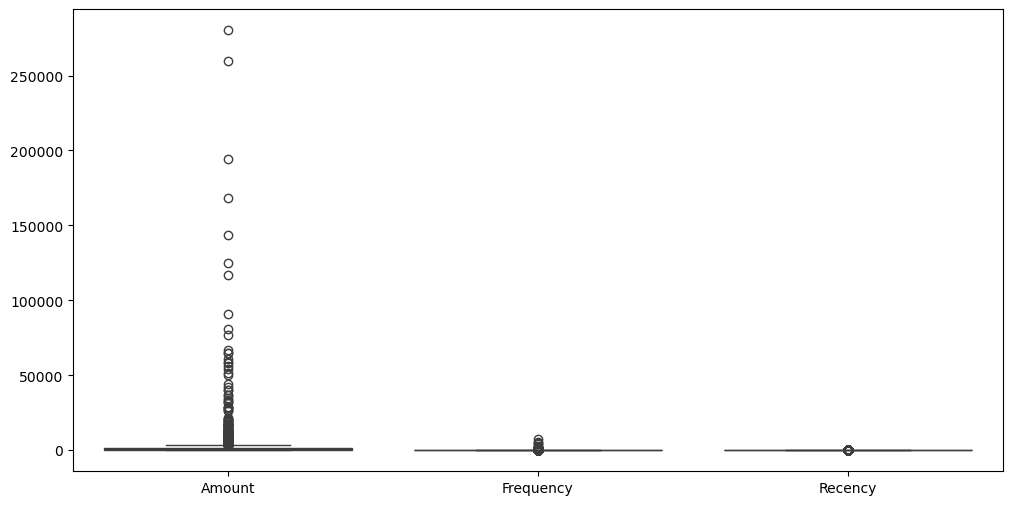

In [22]:
import seaborn as sns
# Create boxplots for key columns
plt.figure(figsize=(12, 6))
sns.boxplot(data=newdf[['Amount','Frequency','Recency']])
plt.show()

We use standardisation here because it is less sensitive to outliers.

### 5.Feature Engineering

#### A.Normalise the Data using Standardisation

In [23]:
rfm_df = newdf[['Amount','Frequency','Recency']]

import sklearn
from sklearn.preprocessing import StandardScaler
#Instanstiate the scaler
scaler=StandardScaler()

rfm_scaled = scaler.fit_transform(rfm_df)
rfm_scaled


array([[ 8.36397668e+00, -3.96968210e-01,  2.33485829e+00],
       [ 2.51778965e-01,  4.05730491e-01, -9.05199314e-01],
       [-2.79383250e-02, -2.63924227e-01, -1.75186336e-01],
       ...,
       [-2.08184524e-01, -3.48185416e-01, -8.45198247e-01],
       [-2.98993684e-04,  2.79608740e+00, -8.85198958e-01],
       [-2.34811224e-02, -9.09670479e-02, -4.95192025e-01]])

#### As the above is an array we will convert it to a dataframe

In [24]:
rfm_scaled = pd.DataFrame(rfm_scaled)
rfm_scaled.columns=['Amount','Frequency','Recency']
rfm_scaled.head()

,Amount,Frequency,Recency
0,8.363977,-0.396968,2.334858
1,0.251779,0.405730,-0.905199
2,-0.027938,-0.263924,-0.175186
3,-0.032357,-0.077663,-0.735196
4,-0.190780,-0.326011,2.174855


#### B.One Hot encoding for Categorical Column


In [26]:
categorical_cols = retail.select_dtypes(include=['object']).columns
categorical_cols

Index(['InvoiceNo', 'StockCode', 'Description', 'Country'], dtype='object')

From the above the only useful columns which can be used for customer segmentation is country. So we will use One hot encoding for country column

In [ ]:
# Apply One-Hot Encoding
df_encoded = pd.get_dummies(df, columns=['Country'])

### 6. Determining Optimal Number of Clusters(by Elbow Method)

In [46]:
from sklearn.cluster import KMeans

# Define the range for K (number of clusters)
wcss = []  
for i in range(2, 11):  # Checking K from 2 to 10
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(rfm_scaled)  # Fit model to scaled data
    wcss.append(kmeans.inertia_)  # Store the WCSS value

In [47]:
wcss

[8990.773641276184,
 5453.366896542007,
 4082.6124237667973,
 2960.551232711668,
 2503.7131083490863,
 1926.0312163470378,
 1765.2542494087647,
 1516.1899830374884,
 1318.5426327501116]

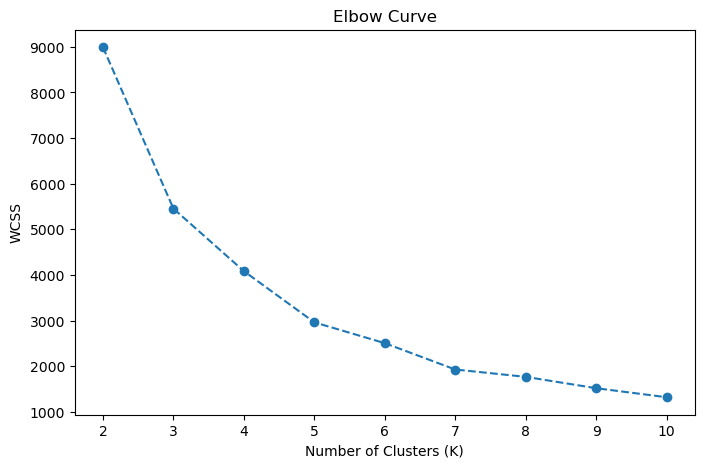

In [48]:
# Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), wcss, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS')
plt.title('Elbow Curve')
plt.show()

The optimal K is where the WCSS stops decreasing rapidly and forms an "elbow." We can see the optimal K would be 3.

### 7. K Mean Clustering with optimal K.

#### A. Run K Mean Clustering with optimal K

In [53]:
k = 3  
kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
rfm_scaled['Cluster'] = kmeans.fit_predict(rfm_scaled)  

#### B. Visualize Clusters with Scatter Plots

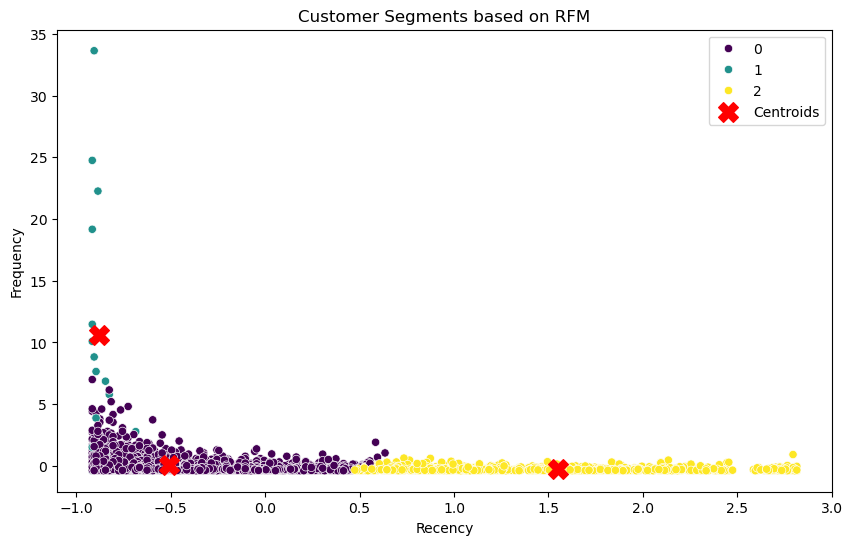

In [54]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=rfm_scaled['Recency'], y=rfm_scaled['Frequency'], hue=rfm_scaled['Cluster'], palette='viridis')
plt.scatter(kmeans.cluster_centers_[:, 2], kmeans.cluster_centers_[:, 1], marker='X', s=200, c='red', label='Centroids')
plt.title('Customer Segments based on RFM')
plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.legend()
plt.show()



#### C. Assign Cluster Labels to Original Data

In [58]:
rfm_scaled['Cluster'] = kmeans.labels_
rfm_scaled['CustomerID'] = newdf['CustomerID']  # Merge with original data
rfm_scaled.head()


,Amount,Frequency,Recency,Cluster,CustomerID
0,8.363977,-0.396968,2.334858,2,12346.0
1,0.251779,0.405730,-0.905199,0,12347.0
2,-0.027938,-0.263924,-0.175186,0,12348.0
3,-0.032357,-0.077663,-0.735196,0,12349.0
4,-0.190780,-0.326011,2.174855,2,12350.0


#### D. Analyze Each Segment (Calculate Summary Statistics:Mean, Median, Standard Deviation)

In [56]:
cluster_summary = rfm_scaled.groupby('Cluster').agg({'Recency': ['mean', 'median', 'std'], 'Frequency': ['mean', 'median', 'std'], 'Amount': ['mean',
                  'median', 'std']}).reset_index()
print(cluster_summary)

  Cluster   Recency                      Frequency                      \
               mean    median       std       mean    median       std   
0       0 -0.510958 -0.625194  0.355948   0.044012 -0.153054  0.593800   
1       1 -0.878532 -0.905199  0.061258  10.623508  7.643323  9.968247   
2       2  1.548876  1.504844  0.667717  -0.280048 -0.321577  0.137069   

      Amount                      
        mean    median       std  
0  -0.004996 -0.125777  0.469528  
1  12.398219  9.908945  9.137585  
2  -0.157332 -0.193490  0.336928  


In [64]:
type(cluster_summary)

pandas.core.frame.DataFrame

### 8.Data Visualization of Clusters

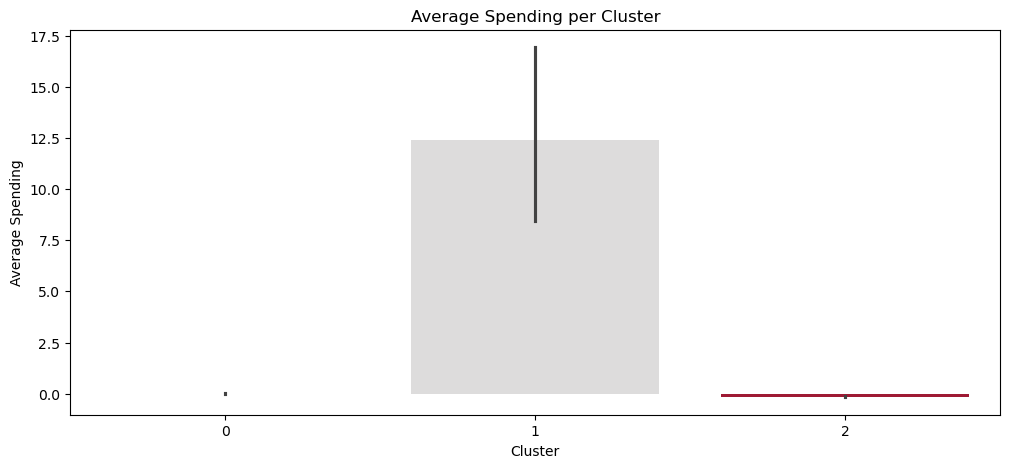

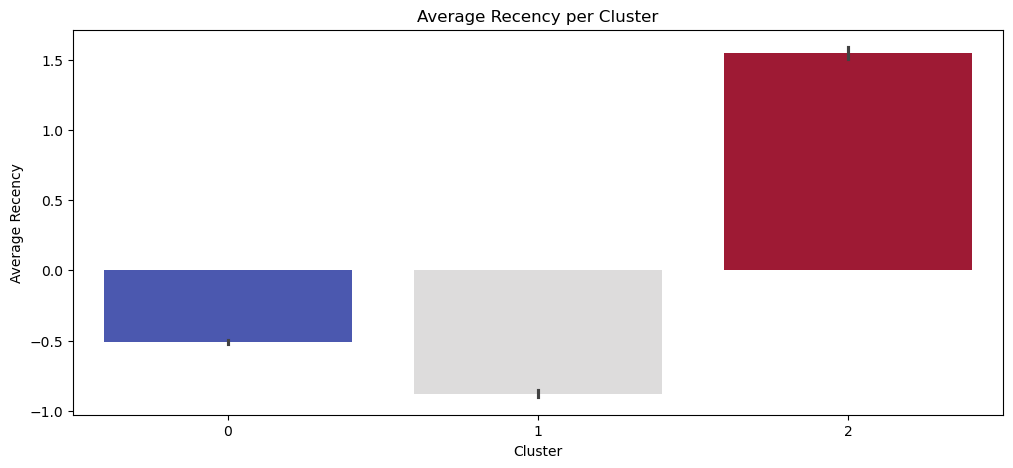

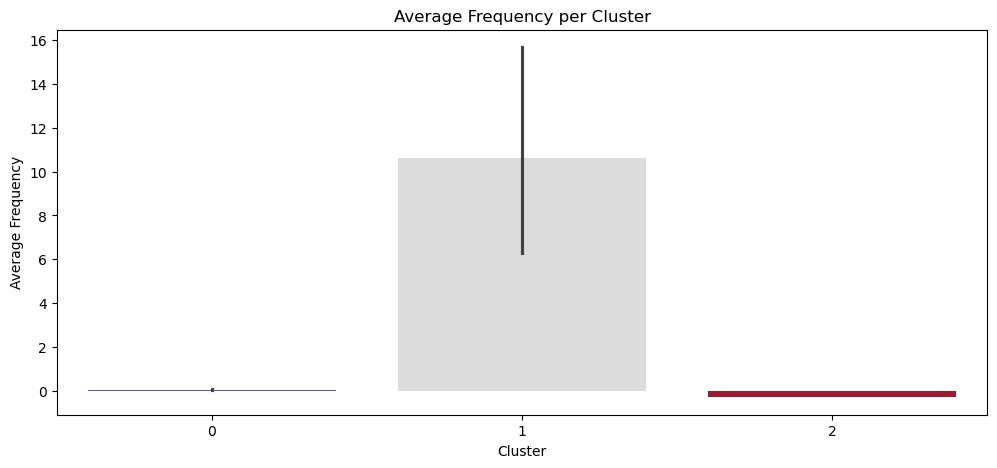

In [62]:
#Average Spending per Cluster
plt.figure(figsize=(12, 5))
sns.barplot(x='Cluster', y='Amount', hue ='Cluster',legend= False,data=rfm_scaled, palette='coolwarm')
plt.xlabel('Cluster')
plt.ylabel('Average Spending')
plt.title('Average Spending per Cluster')
plt.show()

#Average Recency per Cluster
plt.figure(figsize=(12, 5))
sns.barplot(x='Cluster', y='Recency',hue ='Cluster',legend= False, data=rfm_scaled, palette='coolwarm')
plt.xlabel('Cluster')
plt.ylabel('Average Recency')
plt.title('Average Recency per Cluster')
plt.show()

#Average Frequency per Cluster
plt.figure(figsize=(12, 5))
sns.barplot(x='Cluster', y='Frequency', hue ='Cluster',legend= False, data=rfm_scaled, palette='coolwarm')
plt.xlabel('Cluster')
plt.ylabel('Average Frequency')
plt.title('Average Frequency per Cluster')
plt.show()

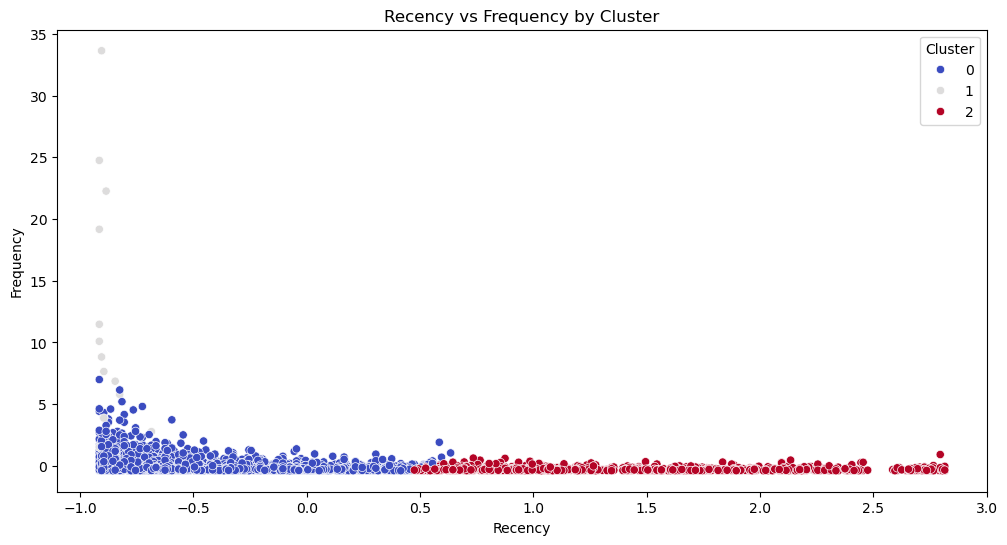

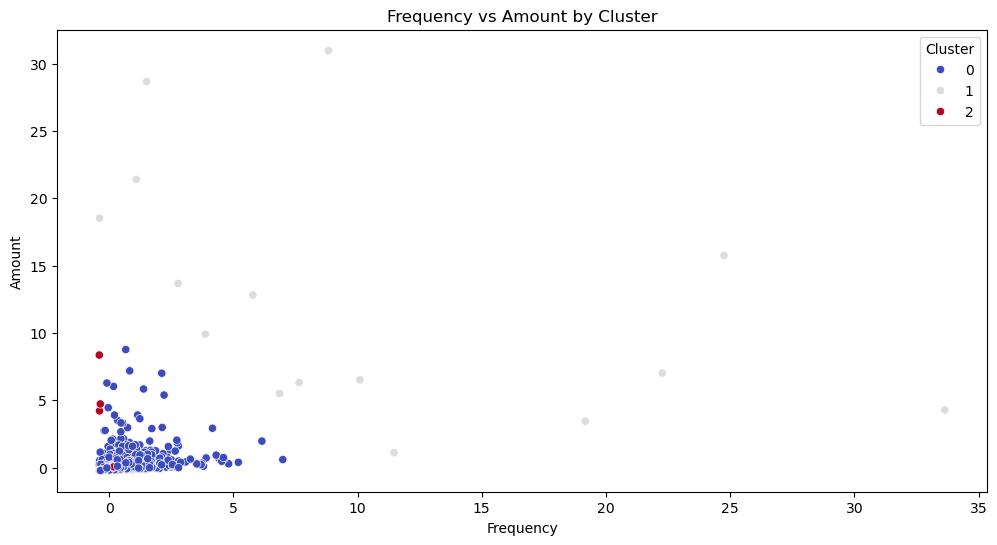

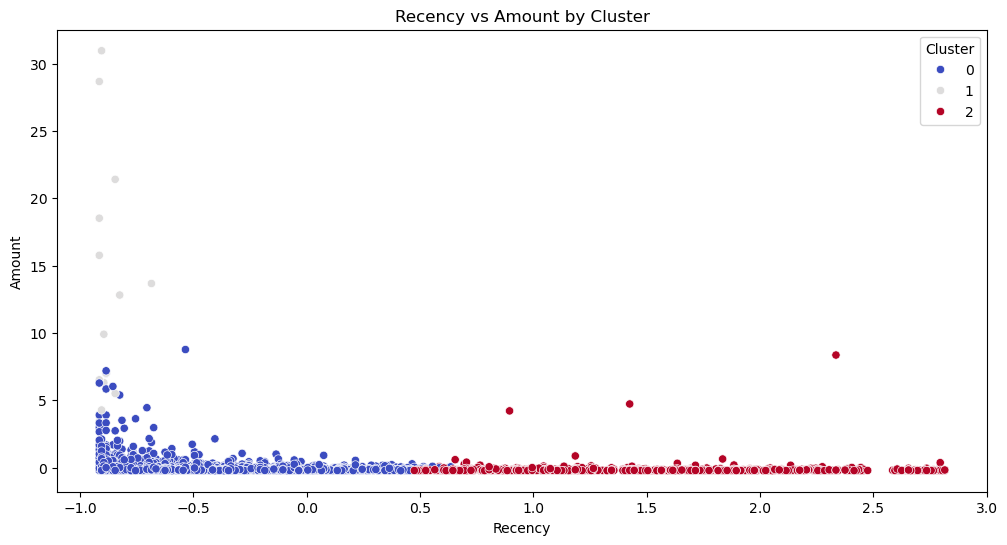

In [65]:
#Scatter plot - Recency vs Frequency
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Recency', y='Frequency', hue='Cluster', data=rfm_scaled, palette='coolwarm')
plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.title('Recency vs Frequency by Cluster')
plt.legend(title='Cluster')
plt.show()

#Scatter plot - Frequency vs Amount
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Frequency', y='Amount', hue='Cluster', data=rfm_scaled, palette='coolwarm')
plt.xlabel('Frequency')
plt.ylabel('Amount')
plt.title('Frequency vs Amount by Cluster')
plt.legend(title='Cluster')
plt.show()

#Scatter plot - Recency vs Amount
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Recency', y='Amount', hue='Cluster', data=rfm_scaled, palette='coolwarm')
plt.xlabel('Recency')
plt.ylabel('Amount')
plt.title('Recency vs Amount by Cluster')
plt.legend(title='Cluster')
plt.show()



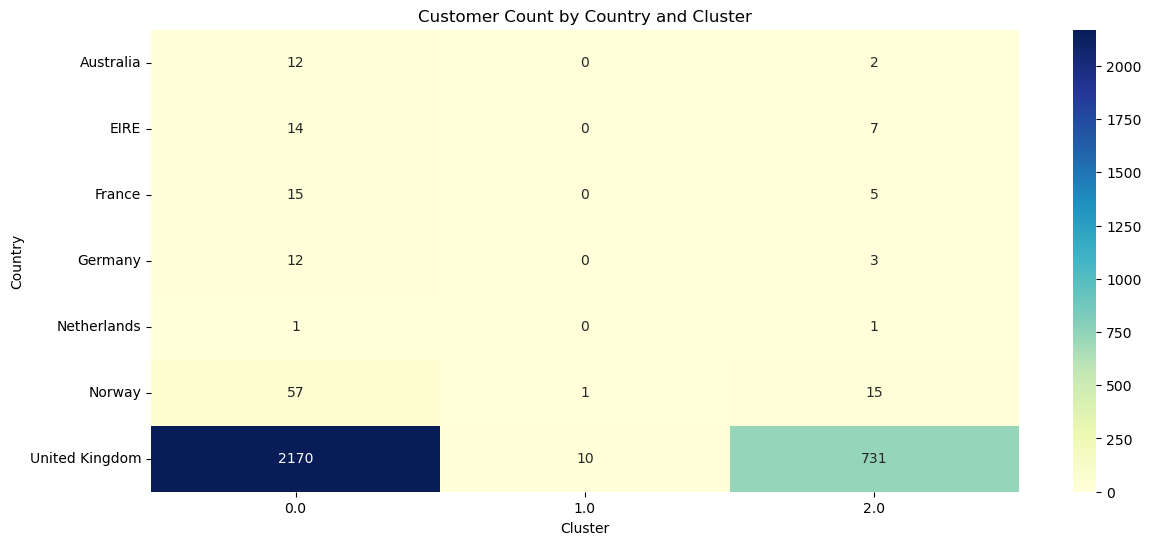

In [69]:
#COUNTRY WISE DISTRIBUTION OF CLUSTERS
#Merge the cluster labels with the original dataset (which includes 'Country')
retail['Cluster'] = rfm_scaled['Cluster']

# Country distribution within each cluster
country_cluster = retail.groupby(['Cluster', 'Country']).size().reset_index(name='Count')

# Plot heatmap
pivot_table = country_cluster.pivot(index='Country', columns='Cluster', values='Count').fillna(0)
plt.figure(figsize=(14, 6))
sns.heatmap(pivot_table, annot=True, fmt='.0f', cmap='YlGnBu')
plt.title('Customer Count by Country and Cluster')
plt.ylabel('Country')
plt.xlabel('Cluster')
plt.show()

### 9.Conclusion:
In this project, I used RFM analysis and K-Means clustering to segment customers based on their purchasing behavior. After data cleaning and feature engineering, I standardized the data and identified three distinct customer segments. These insights can help businesses personalize marketing, improve customer retention, and focus efforts on the most valuable segments. Visualizations further helped in understanding how each group behaves differently in terms of recency, frequency, and spending.